In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR

# model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import re

# evaluation
from sklearn.model_selection import cross_val_score

# metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

SEED=42

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 

# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Data Loading

In [2]:
raw_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
raw_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
exp_data = raw_data.copy()

# Utils

# Exploratory Data Analysis

In [4]:
exp_data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [5]:
exp_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Missing values

In [6]:
exp_data.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Imputation technique:

* Age: This variable will be predicted using a model later after engineering the features to increase dataset performance

* Cabin: The 'Cabin' feature will soon be broken down into 'Deck' feature containing the first letter of the Cabin (e.g. A, B, C, etc.). Missing values will be denoted as 'M' (missing) category since missing can indicate the survival rate of the passenger

* Embarked: Based on research, the 2 passengers with missing 'Embarked' values embarked from 'S' (Southampton)

### Cabin

In [7]:
exp_data['Deck'] = exp_data['Cabin'].str[0]
exp_data['Deck'] = exp_data['Deck'].fillna('M')
exp_data['Deck'].unique()

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [8]:
deck_percentage_pclass = ((exp_data.groupby('Pclass')['Deck']
                   .value_counts()*100/exp_data['Deck'].value_counts())
                   .unstack()
                   .fillna(0))

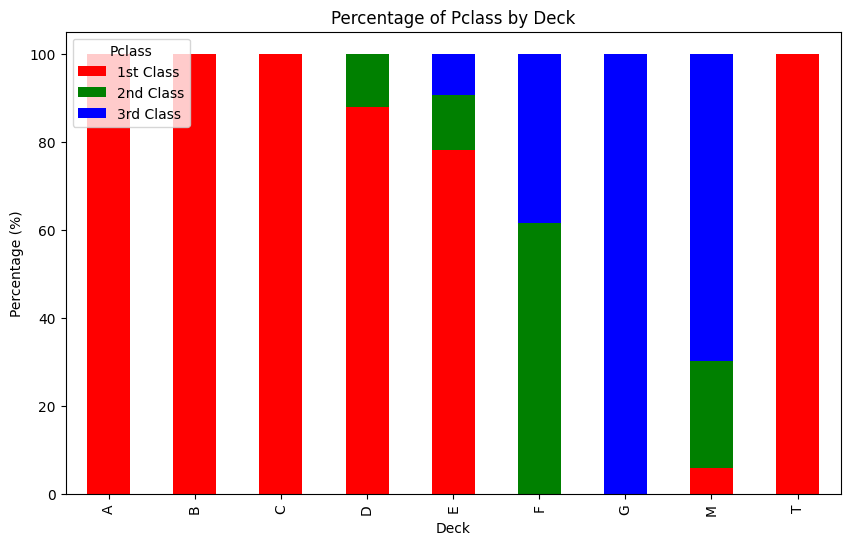

In [9]:
deck_percentage_pclass.T.plot(kind='bar', stacked=True, color=['red', 'green', 'blue'], figsize=(10, 6))
plt.title('Percentage of Pclass by Deck')
plt.xlabel('Deck')
plt.ylabel('Percentage (%)')
plt.legend(['1st Class', '2nd Class', '3rd Class'], title='Pclass', loc='upper left')
plt.show()

For the sake of dimensionality reduction, the decks will be categorized into ABC, DE, FG, and M alone.

Furthermore, due to similar characteristics, T deck will be included in the ABC category.

In [10]:
deck_map = {
    'A': 'ABC',
    'B': 'ABC',
    'C': 'ABC',
    'T': 'ABC',
    'D': 'DE',
    'E': 'DE',
    'F': 'FG',
    'G': 'FG',
    'M': 'M'
}

exp_data['Deck'] = exp_data['Deck'].map(deck_map)

In [11]:
deck_percentage_pclass = ((exp_data.groupby('Pclass')['Deck']
                   .value_counts()*100/exp_data['Deck'].value_counts())
                   .unstack()
                   .fillna(0))

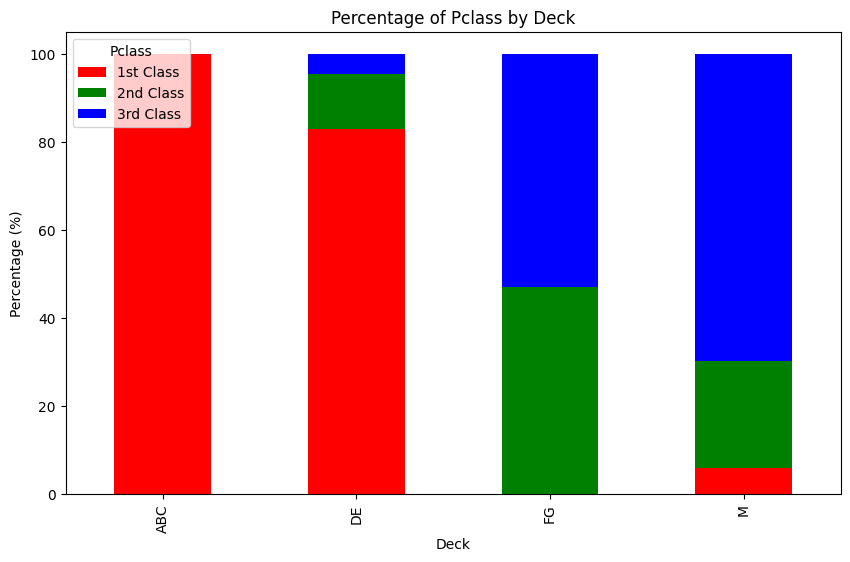

In [12]:
deck_percentage_pclass.T.plot(kind='bar', stacked=True, color=['red', 'green', 'blue'], figsize=(10, 6))
plt.title('Percentage of Pclass by Deck')
plt.xlabel('Deck')
plt.ylabel('Percentage (%)')
plt.legend(['1st Class', '2nd Class', '3rd Class'], title='Pclass', loc='upper left')
plt.show()

In [13]:
exp_data = exp_data.drop('Cabin', axis=1)

### Embarked

I read [gunesevitan's notebook](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial#1.-Exploratory-Data-Analysis) and found this useful information about the 2 passengers with missing 'Embarked' values.



> *When I googled Stone, Mrs. George Nelson (Martha Evelyn), I found that she embarked from S (Southampton) with her maid Amelie Icard, in this page Martha Evelyn Stone: Titanic Survivor.*

> 

> > ***Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.***



Therefore, missing values in embarked will be filled with 'S'.

In [14]:
exp_data['Embarked'] = exp_data['Embarked'].fillna('S')

In [15]:
exp2_data = exp_data.copy()

In [16]:
exp2_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
 10  Deck      891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Target distribution

In [17]:
features = exp2_data.drop('Survived', axis=1)

### Numerical features

In [18]:
numerical_features = features.select_dtypes(['float64']).columns
numerical_features

Index(['Age', 'Fare'], dtype='object')

In [19]:
survived = exp2_data['Survived'] == 1

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

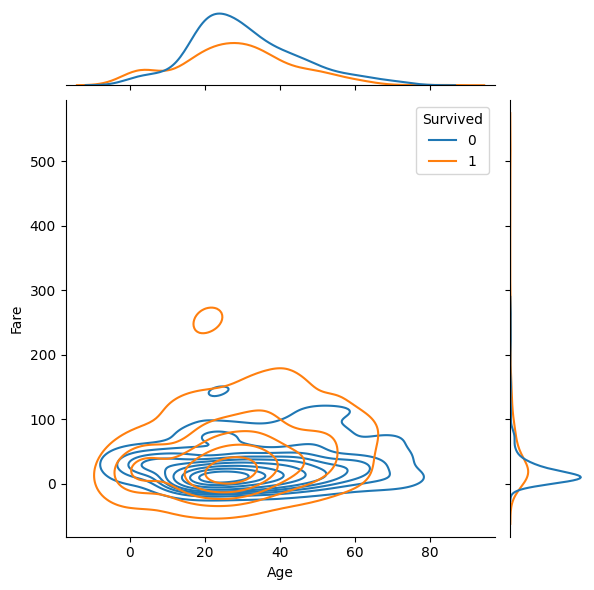

In [20]:
sns.jointplot(x='Age', y='Fare', hue='Survived', data=exp2_data, kind="kde")

### Categorical features

In [21]:
categorical_features = list(set(features.select_dtypes(['int64','object']).columns) - set(['Name','Ticket']))
categorical_features

['Embarked', 'Parch', 'SibSp', 'Deck', 'Pclass', 'Sex']

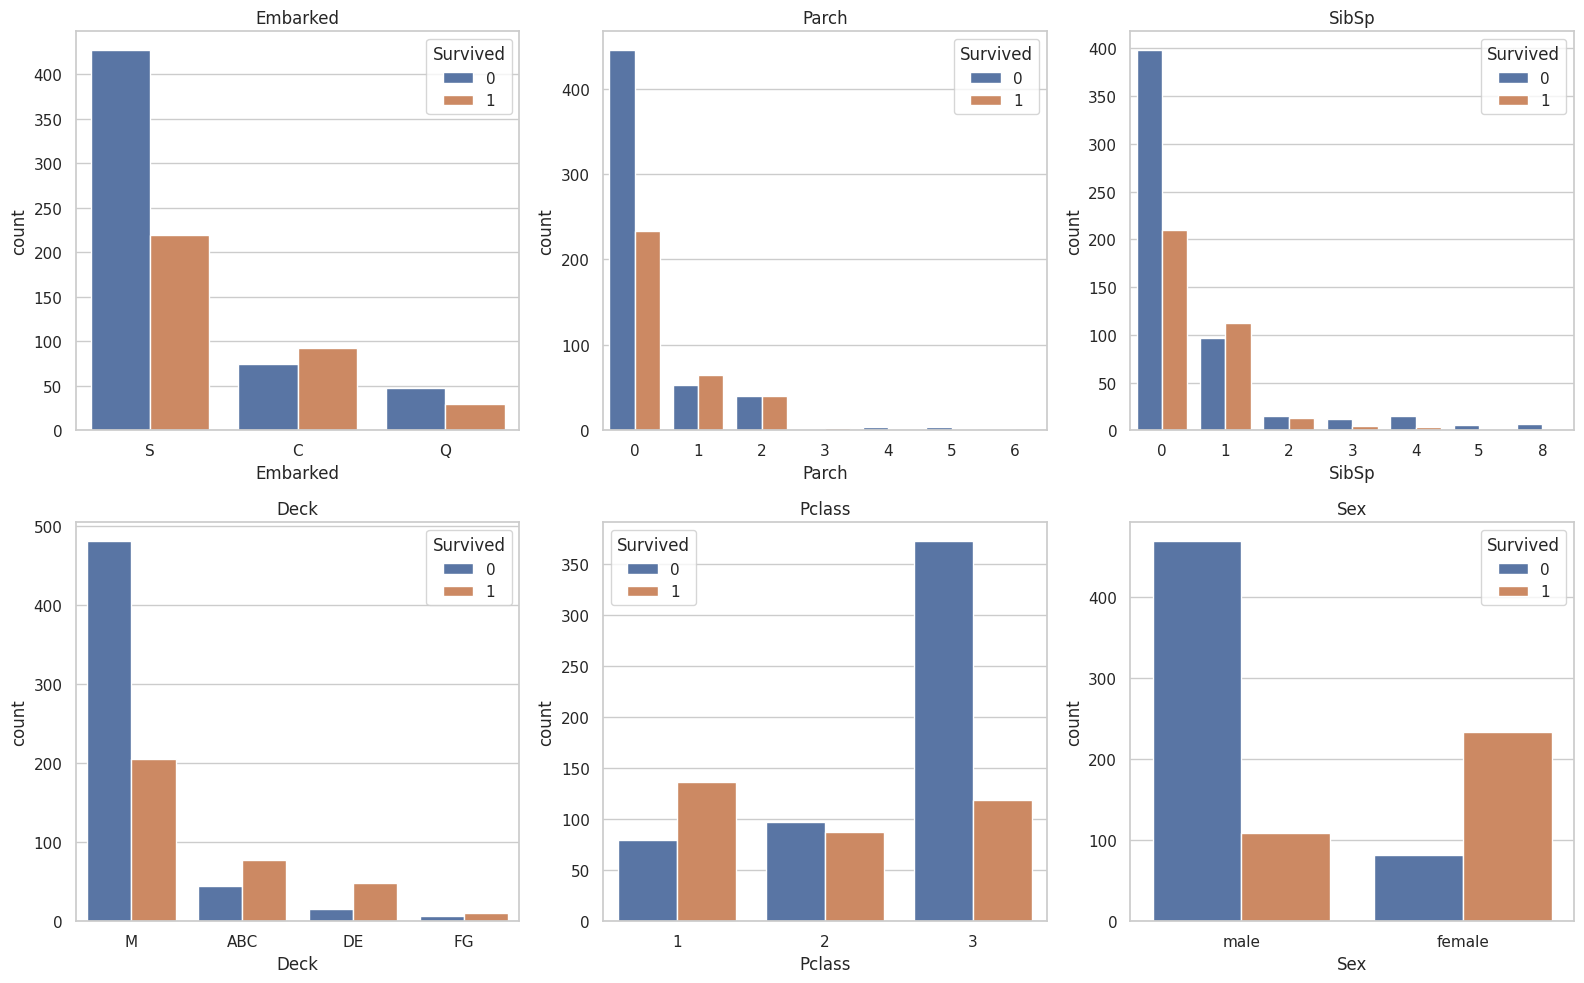

In [22]:
sns.set(style="whitegrid")

# Define number of rows and columns for the subplots grid
num_cols = 3  # Number of plots per row
num_rows = (len(categorical_features) + num_cols - 1) // num_cols  # Calculate required rows

# Create the figure and axis objects for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a violin plot for each categorical variable
for i, categorical in enumerate(categorical_features):
    sns.countplot(x=categorical, hue='Survived', data=exp2_data, ax=axes[i])
    axes[i].set_title(categorical)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

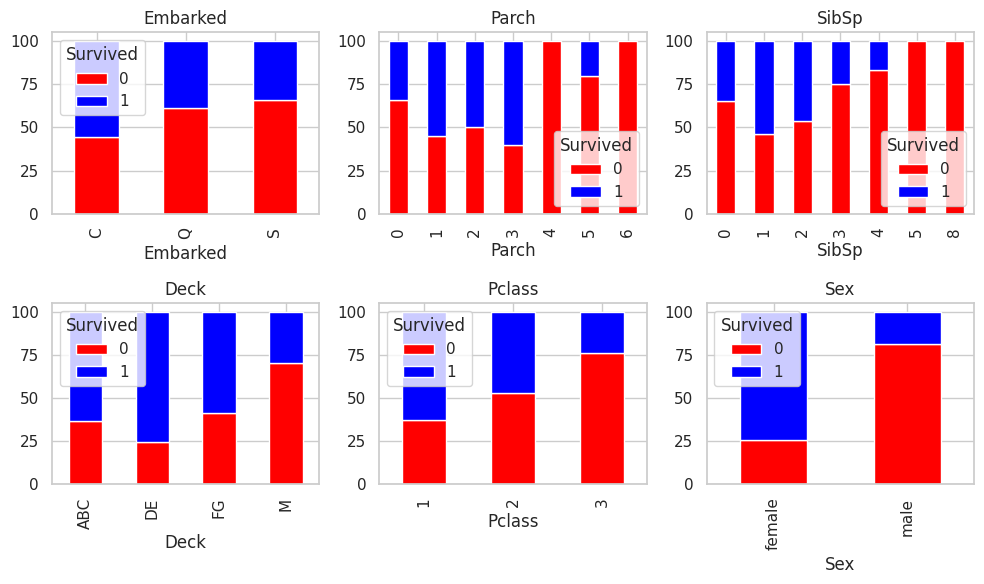

In [23]:
sns.set(style="whitegrid")

# Define number of rows and columns for the subplots grid
num_cols = 3  # Number of plots per row
num_rows = (len(categorical_features) + num_cols - 1) // num_cols  # Calculate required rows

# Create the figure and axis objects for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create a violin plot for each categorical variable
for i, categorical in enumerate(categorical_features):

    percentage_data = ((exp_data.groupby('Survived')[categorical]
                   .value_counts()*100/exp_data[categorical].value_counts())
                   .unstack()
                   .fillna(0))
    percentage_data.T.plot(kind='bar', stacked=True, color=['red', 'blue'], figsize=(10, 6), ax=axes[i])
    axes[i].set_title(categorical)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Feature Engineering

## Frequency encoding

### Family-based

In [24]:
exp2_data['Family_size'] = exp2_data['Parch'] + exp2_data['SibSp'] + 1

exp2_data['Family_size'].unique()

def categorize_family(member):
    if member == 1:
        return 'alone'
    elif member >= 2 and member <= 5:
        return 'small'
    elif member >= 6:
        return 'big'

exp2_data['Family_cat'] = exp2_data['Family_size'].apply(categorize_family)

### Ticket-based

In [25]:
def extract_ticket(ticket):

    non_digit = re.sub('\d', '', ticket)

    if non_digit:

        return non_digit

    else:

        digit = re.search('\d{1,9}', ticket)

        return digit.group() if digit else None

    

def convert_digit(ticket):

    try:

        digit = int(ticket)

        if len(ticket) >= 6:

            return 'big_digit'

        else:

            return 'small_digit'

    except (ValueError, TypeError):

        return ticket

            

# exp2_data['Ticket_extracted'] = exp2_data['Ticket'].apply(extract_ticket).apply(convert_digit)

In [26]:
ticket_map = {

    '_ca': 'C[.]?A[.]?',      # Matches CA or C.A.

    '_PC': 'PC',              # Matches PC

    '_SOTON': 'SOTON',        # Matches SOTON

    '_STON': 'STON',          # Matches STON

    '_WC': 'W[.]?[/]?C',      # Matches WC or W/C

    '_SC': 'S[.]?C[.]?',      # Matches SC or S.C.

    '_A': 'A[.]?',            # Matches A or A.

    '_SOC': 'S[.]?O[.]?[/]?C',# Matches SOC or S.O.C.

    '_PP': 'PP',              # Matches PP

    '_FC': '(F.C.|F.C.C.)',   # Matches F.C. or F.C.C.

    '_big_digit': 'big_digit',# Matches Num_6 or Num_7

    '_small_digit': 'small_digit', # Matches Num_3, Num_4, or Num_5

    'rare': '^[^_]',          # Matches anything not starting with _

}



def map_ticket(ticket):

    ticket = ticket.copy()

    for label, pattern in ticket_map.items():

        # Use .loc to avoid SettingWithCopyWarning

        ticket.loc[ticket.str.contains(pattern)] = label

        

    return ticket



# Apply the function to the 'Ticket_extracted' column

# exp2_data['Ticket_extracted'] = map_ticket(exp2_data['Ticket_extracted'])

In [27]:
exp2_data['Ticket_frequency'] = exp2_data['Ticket'].map(exp2_data['Ticket'].value_counts())

exp2_data['Ticket_frequency'].value_counts()

Ticket_frequency
1    547
2    188
3     63
4     44
7     21
6     18
5     10
Name: count, dtype: int64

In [28]:
exp3_data = exp2_data.copy()

## Name-based encoding

In [29]:
def extract_title(name_series):
    title = name_series.str.extract('([A-Za-z]+)\.')

    return title

In [30]:
exp3_data['Title'] = extract_title(exp3_data['Name'])

In [31]:
exp3_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [32]:
title_map = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mlle': 'Miss',
    'Mrs': 'Mrs',
    'Mme': 'Mrs',
    'Master': 'Master',
    'Don': 'Nobility',
    'Sir': 'Nobility',
    'Countess': 'Nobility',
    'Lady': 'Nobility',
    'Jonkheer': 'Nobility',
    'Dr': 'Professional',
    'Rev': 'Professional',
    'Major': 'Professional',
    'Col': 'Professional',
    'Capt': 'Professional'
}

exp3_data['Title'] = exp3_data['Title'].map(title_map).fillna('Rare')

In [33]:
exp3_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Nobility', 'Professional'],
      dtype=object)

<Axes: xlabel='Title', ylabel='count'>

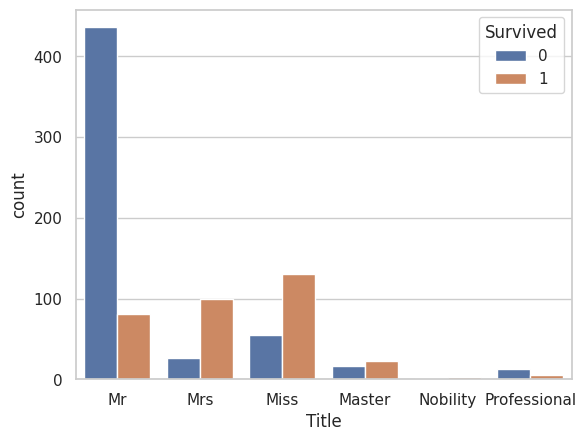

In [34]:
sns.countplot(exp3_data, x='Title', hue='Survived')

In [35]:
def extract_surname(name_series):
    surname = name_series.str.split(',', n=1, expand=True).iloc[:, 0]

    return surname

In [36]:
exp3_data['Family_name'] = extract_surname(exp3_data['Name'])

exp3_data['Family_name'].nunique()

667

## Target encoding

In [37]:
def map_survival_rate(series, mapping, default):
    return series.map(mapping).fillna(default)

family_survival_rate = exp3_data.groupby(['Family_name']).Survived.median()
ticket_survival_rate = exp3_data.groupby(['Ticket']).Survived.median()
default_survival_rate = exp3_data['Survived'].mean()

In [38]:
exp3_data['Family_survival_rate'] = map_survival_rate(exp3_data['Family_name'], family_survival_rate, default_survival_rate)
exp3_data['Ticket_survival_rate'] = map_survival_rate(exp3_data['Ticket'], ticket_survival_rate, default_survival_rate)

<Axes: xlabel='Family_survival_rate', ylabel='count'>

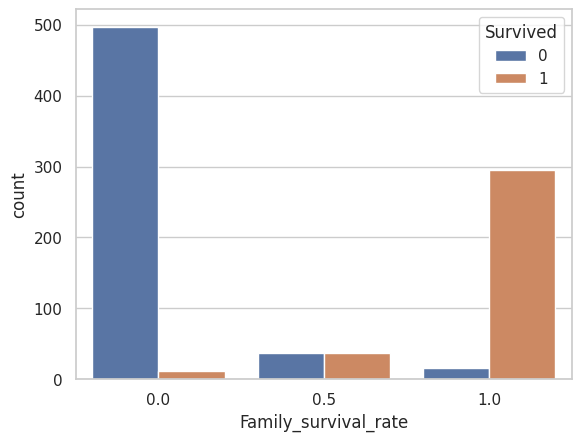

In [39]:
sns.countplot(exp3_data, x='Family_survival_rate', hue='Survived')

<Axes: xlabel='Ticket_survival_rate', ylabel='count'>

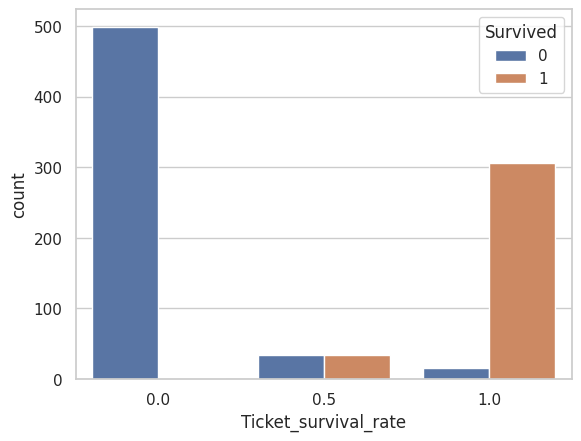

In [40]:
sns.countplot(exp3_data, x='Ticket_survival_rate', hue='Survived')

In [41]:
exp3_data = exp3_data.drop(['Name', 'Ticket', 'Family_name'], axis=1)

exp4_data = exp3_data.copy()

In [42]:
exp4_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Family_size,Family_cat,Ticket_frequency,Title,Family_survival_rate,Ticket_survival_rate
PassengerId,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,M,2,small,1,Mr,0.0,0.0
2,1,1,female,38.0,1,0,71.2833,C,ABC,2,small,1,Mrs,1.0,1.0
3,1,3,female,26.0,0,0,7.9250,S,M,1,alone,1,Miss,1.0,1.0
4,1,1,female,35.0,1,0,53.1000,S,ABC,2,small,2,Mrs,0.5,0.5
5,0,3,male,35.0,0,0,8.0500,S,M,1,alone,1,Mr,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,S,M,1,alone,1,Professional,0.0,0.0
888,1,1,female,19.0,0,0,30.0000,S,ABC,1,alone,1,Miss,1.0,1.0
889,0,3,female,NaN,1,2,23.4500,S,M,4,small,2,Miss,0.0,0.0


## Label and one-hot encoding

### Label encoding

In [43]:
label_features = ['Sex', 'Family_cat']

sex_map = {
    'male': 0,
    'female': 1
}

family_cat_map = {
    'alone': 0,
    'small': 1,
    'big': 2
}

exp4_data['Sex'] = exp4_data['Sex'].map(sex_map)

exp4_data['Family_cat'] = exp4_data['Family_cat'].map(family_cat_map)

In [44]:
exp4_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Family_size,Family_cat,Ticket_frequency,Title,Family_survival_rate,Ticket_survival_rate
PassengerId,,,,,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,S,M,2,1,1,Mr,0.0,0.0
2,1,1,1,38.0,1,0,71.2833,C,ABC,2,1,1,Mrs,1.0,1.0
3,1,3,1,26.0,0,0,7.9250,S,M,1,0,1,Miss,1.0,1.0
4,1,1,1,35.0,1,0,53.1000,S,ABC,2,1,2,Mrs,0.5,0.5
5,0,3,0,35.0,0,0,8.0500,S,M,1,0,1,Mr,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27.0,0,0,13.0000,S,M,1,0,1,Professional,0.0,0.0
888,1,1,1,19.0,0,0,30.0000,S,ABC,1,0,1,Miss,1.0,1.0
889,0,3,1,NaN,1,2,23.4500,S,M,4,1,2,Miss,0.0,0.0


In [45]:
oh_cat = ['Embarked', 'Deck', 'Title']
oh_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_encoded = oh_encoder.fit_transform(exp4_data[oh_cat])
X_encoded_df = pd.DataFrame(X_encoded, columns=oh_encoder.get_feature_names_out(oh_cat))
exp4_data = pd.concat([exp4_data.reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)
exp4_data = exp4_data.drop(oh_cat + ['SibSp', 'Parch'], axis=1)

In [46]:
exp5_data = exp4_data.copy()

In [47]:
exp5_data = exp5_data.drop(['Family_survival_rate', 'Ticket_survival_rate'], axis=1)



## Age imputation

In [48]:
age_known = exp5_data[exp5_data['Age'].notna()]
age_unknown = exp5_data[exp5_data['Age'].isna()]

X_age_known = age_known.drop(['Age', 'Survived'], axis=1)
y_age_known = age_known['Age']
X_age_unknown = age_unknown.drop(['Age', 'Survived'], axis=1)

age_params = {'learning_rate': 0.05, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 1.0}
age_model = GradientBoostingRegressor()
age_model.fit(X_age_known, y_age_known)
age_prediction = age_model.predict(X_age_known)

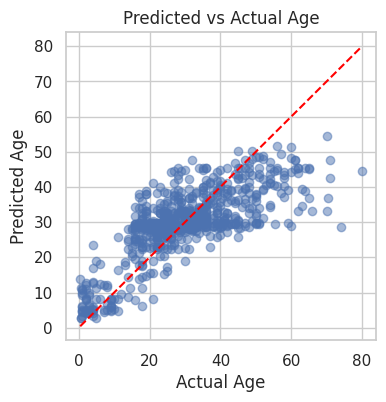

In [49]:
plt.figure(figsize=(4, 4))
plt.scatter(y_age_known, age_prediction, alpha=0.5)
plt.plot([min(y_age_known), max(y_age_known)], [min(y_age_known), max(y_age_known)], color='red', linestyle='--')
plt.title('Predicted vs Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

### Hyperparameter tuning

In [50]:
param_grid_age_model = {
    'n_estimators': [50, 100, 150, 200],            # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],              # Step size shrinkage
    'max_depth': [3, 4, 5, 6],                      # Maximum depth of trees
    'min_samples_split': [2, 5, 10],                # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                  # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8, 1.0],                   # Fraction of samples used for fitting the trees
    'random_state': [SEED],                           # Fix random seed
}



grid_search_age = GridSearchCV(
    estimator=age_model,
    param_grid=param_grid_age_model,
    cv=5,                                         # Number of cross-validation folds
    scoring='neg_mean_squared_error',             # Scoring method
    n_jobs=-1,                                    # Use all available cores
    verbose=2,                                    # Verbosity level
    return_train_score=True                        # Return training scores as well
)

# grid_search_age.fit(X_age_known, y_age_known)

In [51]:
# age_best_params = grid_search_age.best_params_
# age_best_score = grid_search_age.best_score_
# best_age_model = grid_search_age.best_estimator_
# print("Best parameters for Age Model:", age_best_params)
# print("Best score for Age Model:", age_best_score)
# print("Best estimator for Age Model:", best_age_model)



# Best parameters for Age Model: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.8}
# Best score for Age Model: -130.83516660257936
# Best estimator for Age Model: GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
#                           n_estimators=50, random_state=42, subsample=0.8)

age_best_params = {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50, 'random_state': 42, 'subsample': 0.8}

best_age_model = GradientBoostingRegressor(**age_best_params)
best_age_model.fit(X_age_known, y_age_known)

GradientBoostingRegressor(min_samples_leaf=4, min_samples_split=10,
                          n_estimators=50, random_state=42, subsample=0.8)

In [52]:
age_known = exp5_data[exp5_data['Age'].notna()]
age_unknown = exp5_data[exp5_data['Age'].isna()]

X_age_known = age_known.drop(['Age', 'Survived'], axis=1)
y_age_known = age_known['Age']
X_age_unknown = age_unknown.drop(['Age', 'Survived'], axis=1)

age_prediction = best_age_model.predict(X_age_known)

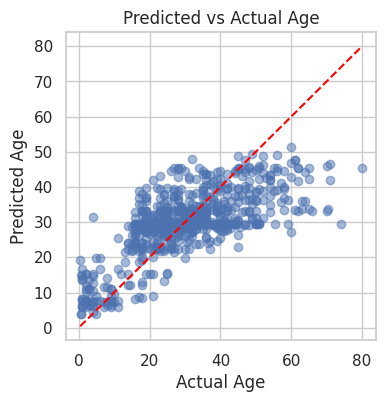

In [53]:
plt.figure(figsize=(4, 4))

plt.scatter(y_age_known, age_prediction, alpha=0.5)
plt.plot([min(y_age_known), max(y_age_known)], [min(y_age_known), max(y_age_known)], color='red', linestyle='--')
plt.title('Predicted vs Actual Age')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.show()

### Predicting age

In [54]:
exp5_data.loc[exp5_data['Age'].isna(), 'Age'] = age_model.predict(X_age_unknown)

## Final create_features function

In [55]:
def impute_df(df_train, df_test):
    mode = ['Pclass', 'Sex']
    none = ['Name', 'Ticket']
    zero = ['SibSp', 'Parch']

    for df in [df_train, df_test]:
        df['Cabin'] = df['Cabin'].fillna('M')

    df_train['Embarked'] = df_train['Embarked'].fillna('S')
    df_test['Embarked'] = df_test['Embarked'].fillna(df_train['Embarked'].mode()[0])

    df_test['Fare'] = df_test['Fare'].fillna(df_train['Fare'].mode()[0])

    for feature in mode:
        df_train[feature] = df_train[feature].fillna(df_train[feature].mode()[0])
        df_test[feature] = df_test[feature].fillna(df_train[feature].mode()[0])

    for feature in none:
        df_train[feature] = df_train[feature].fillna('None')
        df_test[feature] = df_test[feature].fillna('None')

    for feature in zero:
        df_train[feature] = df_train[feature].fillna(0)
        df_test[feature] = df_test[feature].fillna(0)

    fare_by_pclass = df_train.groupby('Pclass')['Fare'].transform('mean')

    df_train['Fare'] = df_train['Fare'].fillna(df_train['Pclass'].map(fare_by_pclass))
    df_test['Fare'] = df_test['Fare'].fillna(df_test['Pclass'].map(fare_by_pclass))

    return df_train, df_test


def cabin_to_deck(df):
    deck_map = {
        'A': 'ABC',
        'B': 'ABC',
        'C': 'ABC',
        'T': 'ABC',
        'D': 'DE',
        'E': 'DE',
        'F': 'FG',
        'G': 'FG',
        'M': 'M'
    }

    df['Deck'] = df['Cabin'].str[0]
    df['Deck'] = df['Deck'].map(deck_map)

    df = df.drop('Cabin', axis=1)

    return df


def categorize_family(member):
    if member == 1:
        return 'alone'
    elif member >= 2 and member <= 5:
        return 'small'
    elif member >= 6:
        return 'big'



def encode_family(df):
    df['Family_size'] = df['Parch'] + df['SibSp'] + 1
    df['Family_cat'] = df['Family_size'].apply(categorize_family)

    return df


def encode_ticket(df_train, df_test):
    ticket_map = df_train['Ticket'].value_counts()
    ticket_map_test = ticket_map + 1

    df_train['Ticket_frequency'] = df_train['Ticket'].map(ticket_map)
    df_test['Ticket_frequency'] = df_test['Ticket'].map(ticket_map_test).fillna(1)
    
    return df_train, df_test
    

def extract_title(name_series):
    title = name_series.str.extract('([A-Za-z]+)\.')
    
    return title
    

def extract_surname(name_series):
    surname = name_series.str.split(',', n=1, expand=True).iloc[:, 0]
    
    return surname
    

def encode_name(df):

    title_map = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Ms': 'Miss',
        'Mlle': 'Miss',
        'Mrs': 'Mrs',
        'Mme': 'Mrs',
        'Master': 'Master',
        'Don': 'Nobility',
        'Sir': 'Nobility',
        'Countess': 'Nobility',
        'Lady': 'Nobility',
        'Jonkheer': 'Nobility',
        'Dr': 'Professional',
        'Rev': 'Professional',
        'Major': 'Professional',
        'Col': 'Professional',
        'Capt': 'Professional'
    }

    df['Title'] = extract_title(df['Name'])
    df['Title'] = df['Title'].map(title_map).fillna('Rare')

    df['Family_name'] = extract_surname(df['Name'])

    return df


def map_survival_rate(series, mapping, default):
    
    return series.map(mapping).fillna(default)


def target_encoding(df_train, df_test):
    family_survival_rate = df_train.groupby(['Family_name']).Survived.median()
    ticket_survival_rate = df_train.groupby(['Ticket']).Survived.median()
    default_survival_rate = df_train['Survived'].mean()

    df_train['Family_survival_rate'] = map_survival_rate(df_train['Family_name'], family_survival_rate, default_survival_rate)
    df_test['Family_survival_rate'] = map_survival_rate(df_test['Family_name'], family_survival_rate, default_survival_rate)

    df_train['Ticket_survival_rate'] = map_survival_rate(df_train['Ticket'], ticket_survival_rate, default_survival_rate)
    df_test['Ticket_survival_rate'] = map_survival_rate(df_test['Ticket'], ticket_survival_rate, default_survival_rate)
    
    return df_train, df_test


def label_encoding(df):
    label_features = ['Sex', 'Family_cat']
    
    sex_map = {
        'male': 0,
        'female': 1
    }
    
    family_cat_map = {
        'alone': 0,
        'small': 1,
        'big': 2
    }

    df['Sex'] = df['Sex'].map(sex_map)
    df['Family_cat'] = df['Family_cat'].map(family_cat_map)

    return df


def onehot_encoding(df_train, df_test):

    oh_cat = ['Embarked', 'Deck', 'Title']
    oh_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    
    train_encoded = oh_encoder.fit_transform(df_train[oh_cat])
    test_encoded = oh_encoder.transform(df_test[oh_cat])

    df_train_encoded = pd.DataFrame(train_encoded, columns=oh_encoder.get_feature_names_out(oh_cat))
    df_test_encoded = pd.DataFrame(test_encoded, columns=oh_encoder.get_feature_names_out(oh_cat))

    df_train = pd.concat([df_train.reset_index(drop=True), df_train_encoded.reset_index(drop=True)], axis=1)
    df_test = pd.concat([df_test.reset_index(drop=True), df_test_encoded.reset_index(drop=True)], axis=1)

    return df_train, df_test

    
def impute_age(df_train, df_test):

    train_age_known = df_train[df_train['Age'].notna()]
    train_age_unknown = df_train[df_train['Age'].isna()]
    test_age_unknown = df_test[df_test['Age'].isna()]

    X_train_age_known = train_age_known.drop(['Survived', 'Age'], axis=1)
    y_train_age_known = train_age_known['Age']
    X_train_age_unknown = train_age_unknown.drop(['Survived', 'Age'], axis=1)
    X_test_age_unknown = test_age_unknown.drop('Age', axis=1)

    df_train.loc[df_train['Age'].isna(), 'Age'] = best_age_model.predict(X_train_age_unknown)
    df_test.loc[df_test['Age'].isna(), 'Age'] = best_age_model.predict(X_test_age_unknown)

    return df_train, df_test


def create_features(df_train, df_test):

    df_train, df_test = impute_df(df_train, df_test)
    
    df_train = cabin_to_deck(df_train)
    df_test = cabin_to_deck(df_test)

    df_train = encode_family(df_train)
    df_test = encode_family(df_test)
    
    df_train, df_test = encode_ticket(df_train, df_test)

    df_train = encode_name(df_train)
    df_test = encode_name(df_test)

    # df_train, df_test = target_encoding(df_train, df_test)

    df_train = label_encoding(df_train)
    df_test = label_encoding(df_test)

    df_train, df_test = onehot_encoding(df_train, df_test)

    df_train = df_train.drop(oh_cat + ['Name', 'Ticket', 'Family_name', 'SibSp', 'Parch'], axis=1)
    df_test = df_test.drop(oh_cat + ['Name', 'Ticket', 'Family_name', 'SibSp', 'Parch'], axis=1)

    df_train, df_test = impute_age(df_train, df_test)

    return df_train, df_test

# Model Building

In [56]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')

test_data = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')

ids = test_data.index

In [57]:
train_df, test_df = create_features(train_data, test_data)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [58]:
X = train_df.drop('Survived', axis=1)

y = train_df['Survived']

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [60]:
model = XGBClassifier()

model.fit(X_train, y_train)

prediction = model.predict(X_train)

In [61]:
accuracy = accuracy_score(y_train, prediction)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_train, prediction))

print("Confusion Matrix:")
print(confusion_matrix(y_train, prediction))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       444
           1       0.99      0.95      0.97       268

    accuracy                           0.98       712
   macro avg       0.98      0.97      0.98       712
weighted avg       0.98      0.98      0.98       712

Confusion Matrix:
[[442   2]
 [ 14 254]]


In [62]:
prediction = model.predict(X_valid)

In [63]:
accuracy = accuracy_score(y_valid, prediction)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix

print("Classification Report:")
print(classification_report(y_valid, prediction))

print("Confusion Matrix:")
print(confusion_matrix(y_valid, prediction))

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       105
           1       0.77      0.76      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

Confusion Matrix:
[[88 17]
 [18 56]]


## Hyperparameter tuning

In [64]:
param_grid_model = {
    'n_estimators': [50, 100, 150, 200],            # Number of boosting rounds
    'learning_rate': [0.001, 0.01, 0.1, 0.2],       # Step size shrinkage
    'max_depth': [3, 4, 5, 6],                      # Maximum depth of trees
    'min_child_weight': [1, 3, 5],                  # Minimum sum of instance weight in a child
    'gamma': [0, 0.1, 0.2, 0.3],                    # Minimum loss reduction for a partition
    'subsample': [0.6, 0.7, 0.8, 0.9],              # Subsample ratio for training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],       # Subsample ratio of columns
    'scale_pos_weight': [1, 3, 5],                  # Weight balance for imbalanced classes
    'random_state': [SEED],                           # Fix random seed
}

In [65]:
grid_search_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid_model,
    cv=5,                                         # Number of cross-validation folds
    scoring='accuracy',                           # Scoring method
    n_jobs=-1,                                    # Use all available cores
    verbose=2,                                    # Verbosity level
    return_train_score=True                        # Return training scores as well
)

# grid_search_model.fit(X_train, y_train)

In [66]:
# best_params = grid_search_model.best_params_
# best_score = grid_search_model.best_score_
# best_model = grid_search_model.best_estimator_
# print("Best parameters for Model:", best_params)
# print("Best score for Model:", best_score)
# print("Best estimator for Model:", best_model)

# Best parameters for Model: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50, 'random_state': 42, 'scale_pos_weight': 1, 'subsample': 0.8}
# Best score for Model: 0.8454742440657934
# Best estimator for Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
#               colsample_bylevel=None, colsample_bynode=None,
#               colsample_bytree=0.6, device=None, early_stopping_rounds=None,
#               enable_categorical=False, eval_metric=None, feature_types=None,
#               gamma=0, grow_policy=None, importance_type=None,
#               interaction_constraints=None, learning_rate=0.1, max_bin=None,
#               max_cat_threshold=None, max_cat_to_onehot=None,
#               max_delta_step=None, max_depth=4, max_leaves=None,
#               min_child_weight=5, missing=nan, monotone_constraints=None,
#               multi_strategy=None, n_estimators=50, n_jobs=None,
#               num_parallel_tree=None, random_state=42, ...)

best_params = {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 0.8}

n_models = 100
models = []

for i in range(n_models):
    best_model = XGBClassifier(**best_params, random_state=i)
    best_model.fit(X_train, y_train)
    models.append(best_model)

In [67]:
predictions = np.array([model.predict(X_train) for model in models])
ensemble_predictions = (np.mean(predictions, axis=0) > 0.5).astype(int)

In [68]:
accuracy = accuracy_score(y_train, ensemble_predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix

print("Classification Report:")
print(classification_report(y_train, ensemble_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_train, ensemble_predictions))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       444
           1       0.87      0.75      0.81       268

    accuracy                           0.87       712
   macro avg       0.87      0.84      0.85       712
weighted avg       0.87      0.87      0.86       712

Confusion Matrix:
[[414  30]
 [ 66 202]]


In [69]:
predictions = np.array([model.predict(X_valid) for model in models])
ensemble_predictions = (np.mean(predictions, axis=0) > 0.5).astype(int)

In [70]:
accuracy = accuracy_score(y_valid, ensemble_predictions)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report and confusion matrix

print("Classification Report:")
print(classification_report(y_valid, ensemble_predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_valid, ensemble_predictions))

Accuracy: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       105
           1       0.82      0.80      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179

Confusion Matrix:
[[92 13]
 [15 59]]


# Submission

In [71]:
predictions = np.array([model.predict(test_df) for model in models])
ensemble_predictions = (np.mean(predictions, axis=0) > 0.5).astype(int)

output = pd.DataFrame({'Id': ids,
                       'Survived': ensemble_predictions.squeeze()})
output.head()

,Id,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [72]:
sample_submission_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
sample_submission_df['Survived'] = ensemble_predictions
sample_submission_df.to_csv('submission.csv', index=False)
sample_submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
